# Image Preprocessing

In [1]:
import cv2, glob, os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import io
from skimage import io

In [2]:
def estimate_radius(img):
    mx = img[img.shape[0] // 2,:,:].sum(1)
    rx = (mx > mx.mean() / 10).sum() / 2
    
    my = img[:,img.shape[1] // 2,:].sum(1)
    ry = (my > my.mean() / 10).sum() / 2

    return (ry, rx)

def crop_img(img, h, w):
    h_margin = (img.shape[0] - h) // 2 if img.shape[0] > h else 0
    w_margin = (img.shape[1] - w) // 2 if img.shape[1] > w else 0

    crop_img = img[h_margin:h + h_margin,w_margin:w + w_margin,:]

    return crop_img

def remove_outer_circle(a, p, r):
    b = np.zeros(a.shape, dtype=np.uint8)
    cv2.circle(b, (a.shape[1] // 2, a.shape[0] // 2), int(r * p), (1, 1, 1), -1, 8, 0)
    
    return a * b + 128 * (1 - b)

def place_in_square(img, r, h, w):
    new_img = np.zeros((2 * r, 2 * r, 3), dtype=np.uint8)
    new_img += 128
    new_img[r - h // 2:r - h // 2 + img.shape[0], r - w // 2:r - w // 2 + img.shape[1]] = img
    
    return new_img


In [3]:
def apply_Gaussian_blur(img):
    gb_img = cv2.GaussianBlur(img, (0, 0), 5)
    
    return cv2.addWeighted(img, 4, gb_img, -4, 128)


In [4]:
def apply_Clahe(img, method = 'CLAHE'):
   
    b,g,r = cv2.split(img)
    if method == 'HE':
        cv2.equalizeHist(b,b)
        cv2.equalizeHist(g,g)
        cv2.equalizeHist(r,r)
    else:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe.apply(g,g)
        if not method =='CLAHE_G':
            clahe.apply(b,b)
            clahe.apply(r,r)
            
    img = cv2.merge((b,g,r))
            
    return img


In [5]:
# target radius
scale = 256 

def image_preprocess(path, first, method='GAUSSIAN'):
    img = io.imread(path)
    ry, rx = estimate_radius(img)
   
    resize_scale = scale / max(rx, ry)
    w = min(int(rx * resize_scale * 2), scale * 2)
    h = min(int(ry * resize_scale * 2), scale * 2)
    
    if(first):
        print("Original image")
        plt.imshow(img)
        plt.show() 
        
    img = cv2.resize(img, (0, 0), fx=resize_scale, fy=resize_scale)
    
    img = crop_img(img, h, w)
    if(first):
        print("After cropping")
        plt.imshow(img)
        plt.show() 
        
    if(method=='CLAHE'):
        img = apply_Clahe(img)
        if(first):
            print("After applying CLAHE")
            plt.imshow(img)
            plt.show()   
    else:
        img = apply_Gaussian_blur(img)
        if(first):
            print("After applying Gaussian")
            plt.imshow(img)
            plt.show()   
            
    img = remove_outer_circle(img, 0.9, scale)
    if(first):
        print("After removing outer circle")
        plt.imshow(img)
        plt.show()
        
    img = place_in_square(img, scale, h, w)
    if(first):
        print("After placing in square")
        plt.imshow(img)
        plt.show()
        
    return img


Original image


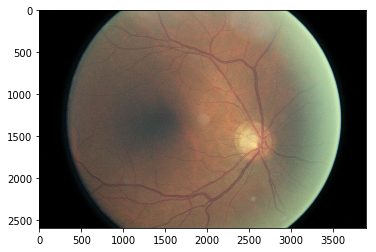

After cropping


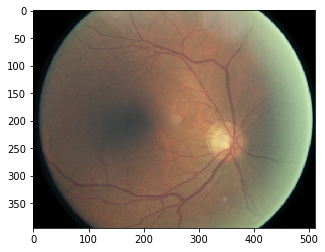

After applying Gaussian


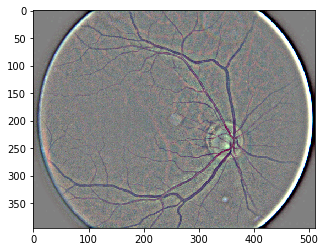

After removing outer circle


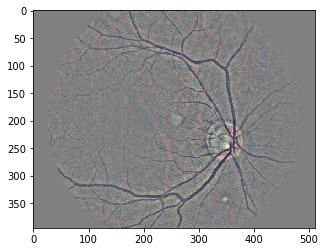

After placing in square


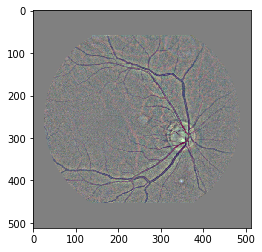

In [ ]:
# name of the directory with original train data
dir_path = "train_even5500"

# name of the directory to put the pre-processed images
output_path = "train_even_5500_GAUSSIAN512"

if not os.path.exists(output_path):
    os.mkdir(output_path)
first = True;
for file_name in os.listdir(dir_path):
    if "jpeg" in file_name:
        path = "{}/{}".format(dir_path, file_name)
        output = "{}/{}".format(output_path, file_name)
        
        img = image_preprocess(path, first)
        first = False;
        plt.imsave(output, img)